In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [138]:
# Alle Datensätze
data0 = np.loadtxt('data/zeemann_data/ZeemanX_ohneB.txt', delimiter=';')
data_mess = np.loadtxt('data/zeemann_data/ZeemanX_mitB.txt', delimiter=';')
data1 = np.loadtxt('data/zeemann_data/ZeemanX_1A.txt', delimiter=';')
data2 = np.loadtxt('data/zeemann_data/ZeemanX_2A.txt', delimiter=';')
data3 = np.loadtxt('data/zeemann_data/ZeemanX_3A.txt', delimiter=';')
data4 = np.loadtxt('data/zeemann_data/ZeemanX_4A.txt', delimiter=';')
data5 = np.loadtxt('data/zeemann_data/ZeemanX_5A.txt', delimiter=';')
data6 = np.loadtxt('data/zeemann_data/ZeemanX_6A.txt', delimiter=';')
data7 = np.loadtxt('data/zeemann_data/ZeemanX_7A.txt', delimiter=';')
data8 = np.loadtxt('data/zeemann_data/ZeemanX_8A.txt', delimiter=';')
data9 = np.loadtxt('data/zeemann_data/ZeemanX_9A.txt', delimiter=';')
data10 = np.loadtxt('data/zeemann_data/ZeemanX_10A.txt', delimiter=';')

alldata = np.array([data0, data_mess, data1, data2, data3, data4, data5, data6, data7, data8, data9, data10])
dataB = np.array([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10])

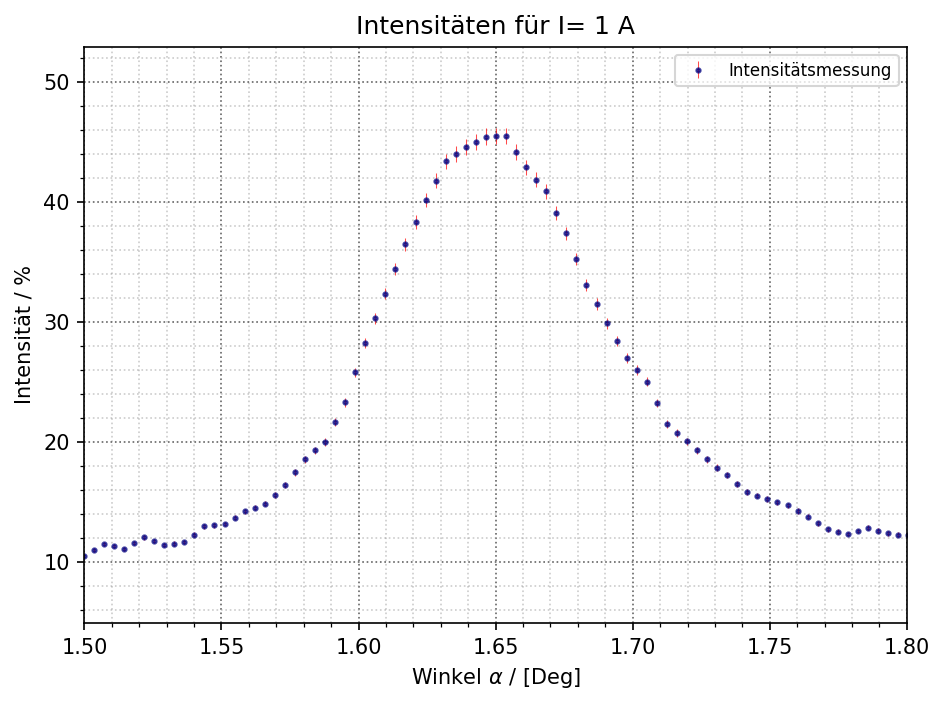

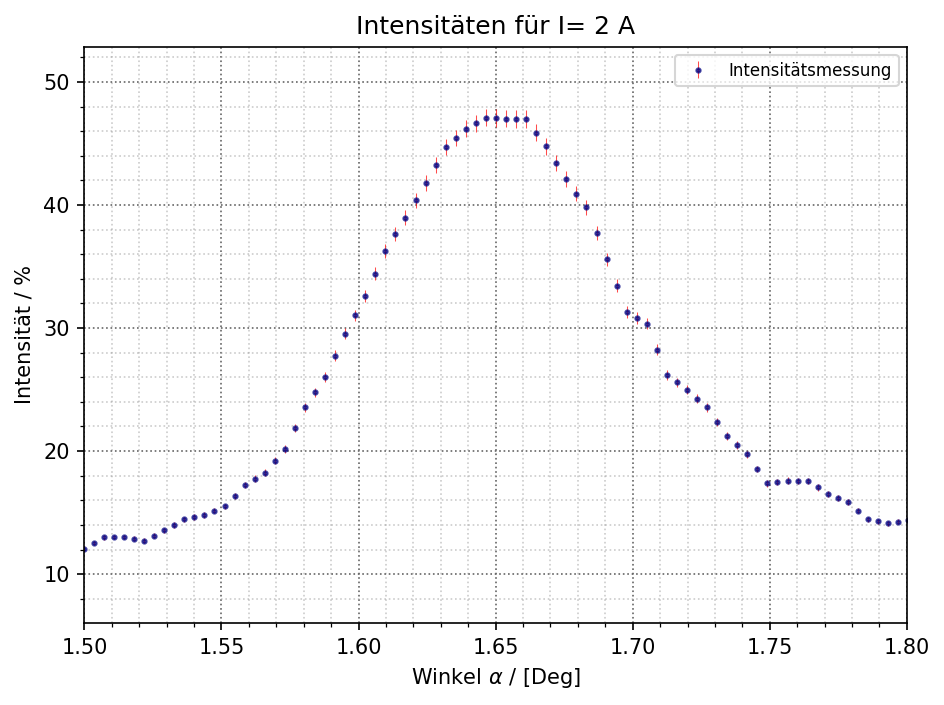

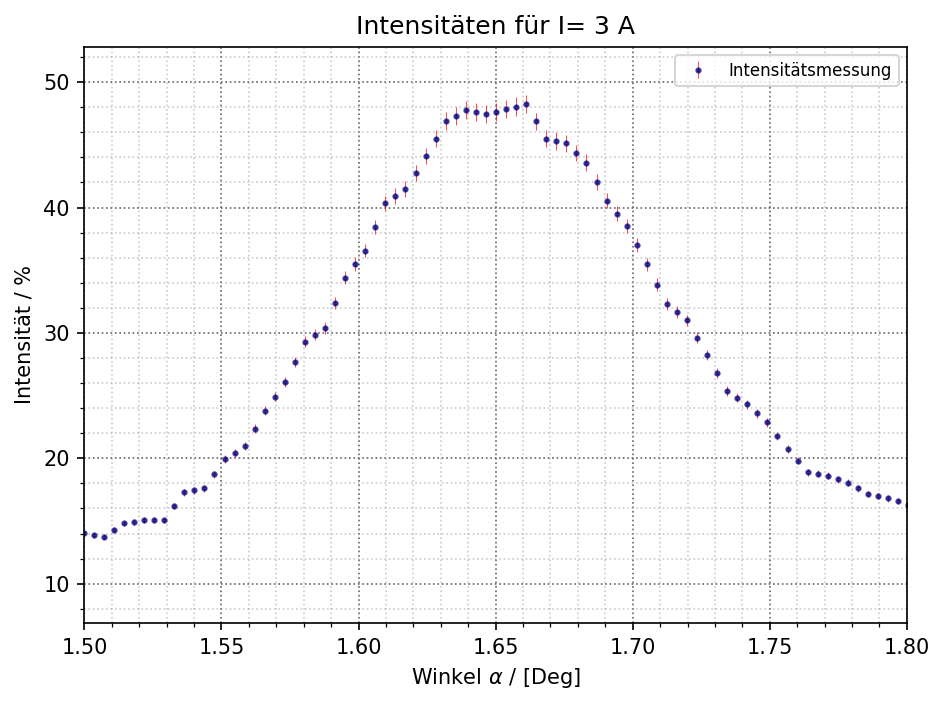

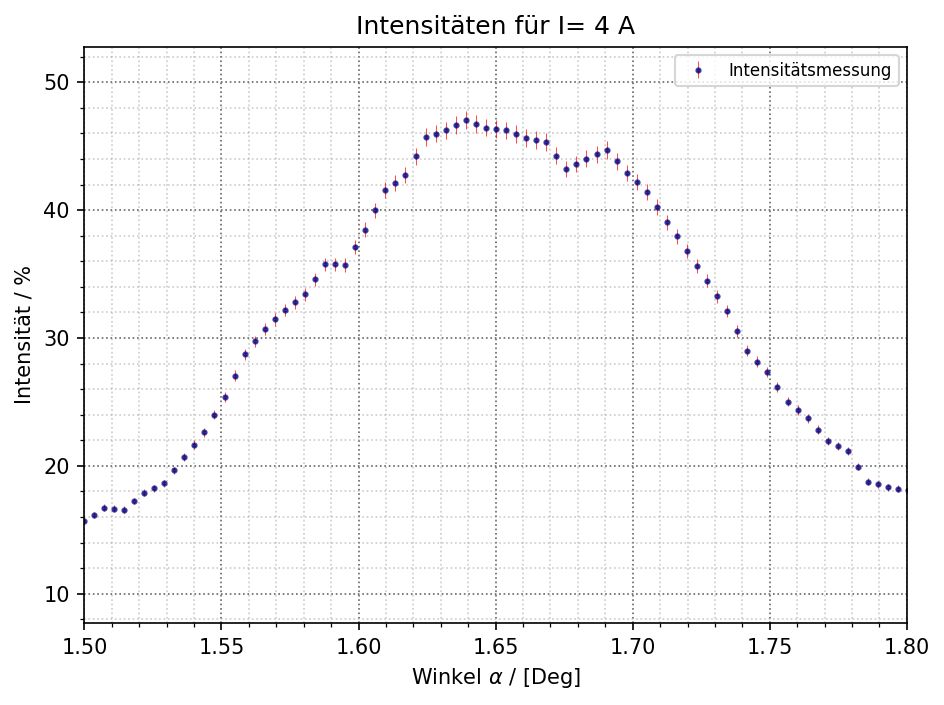

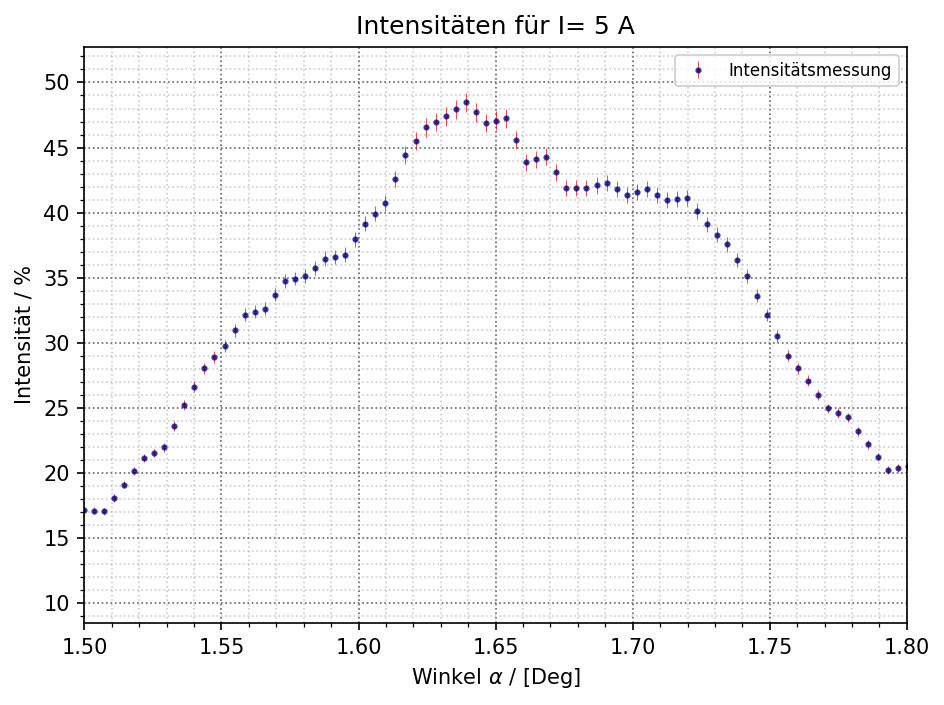

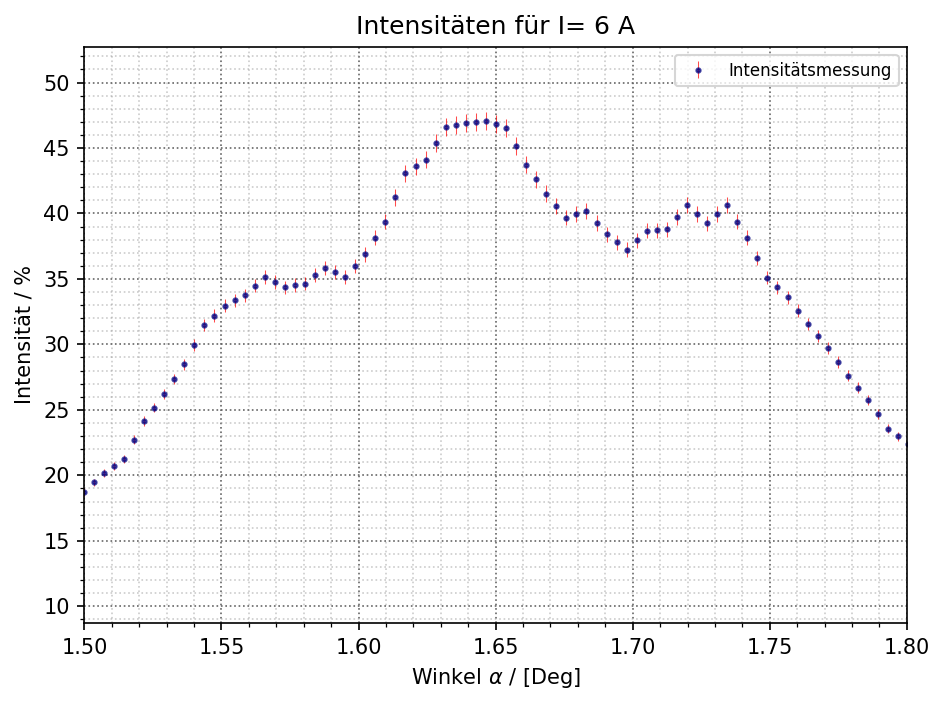

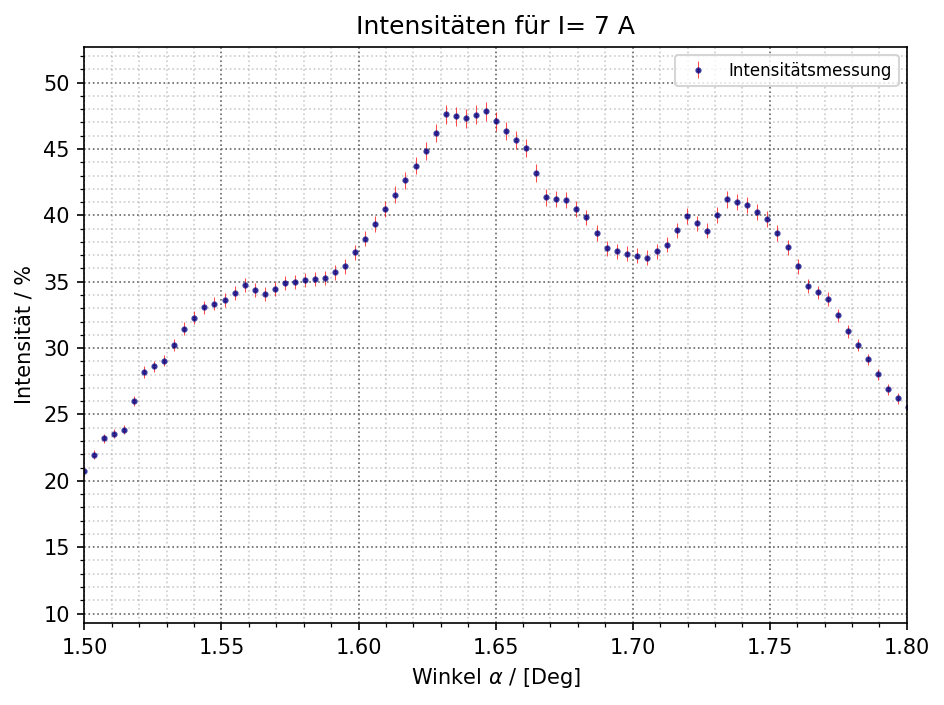

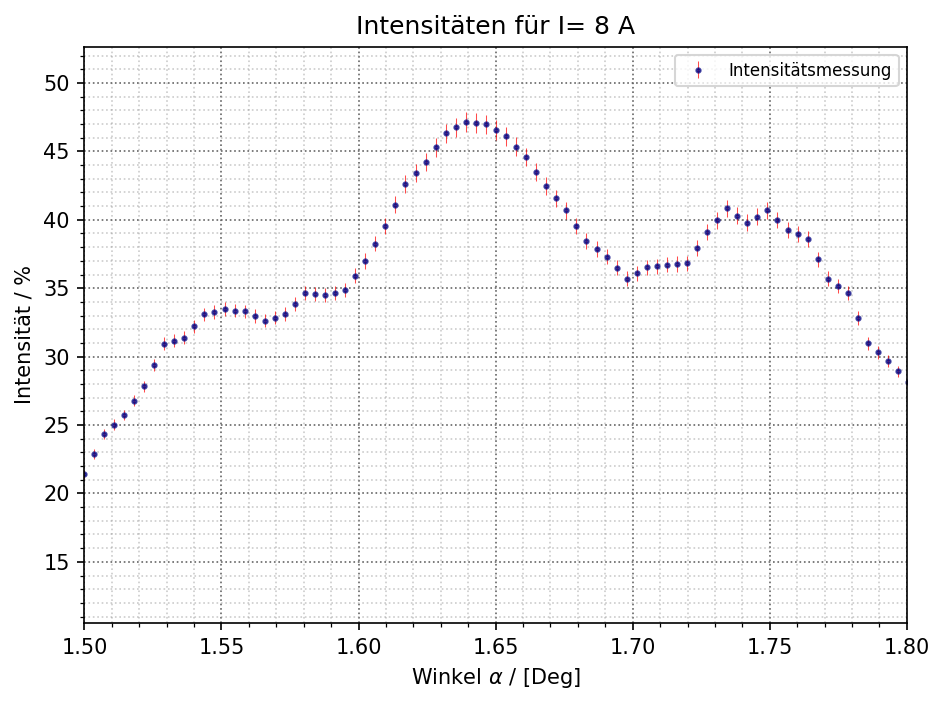

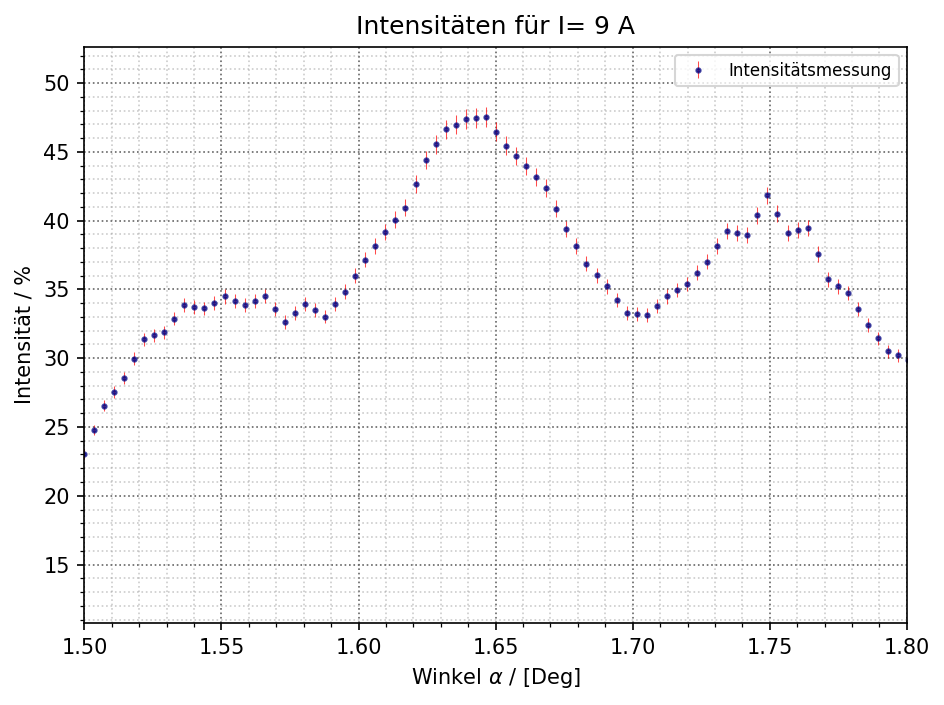

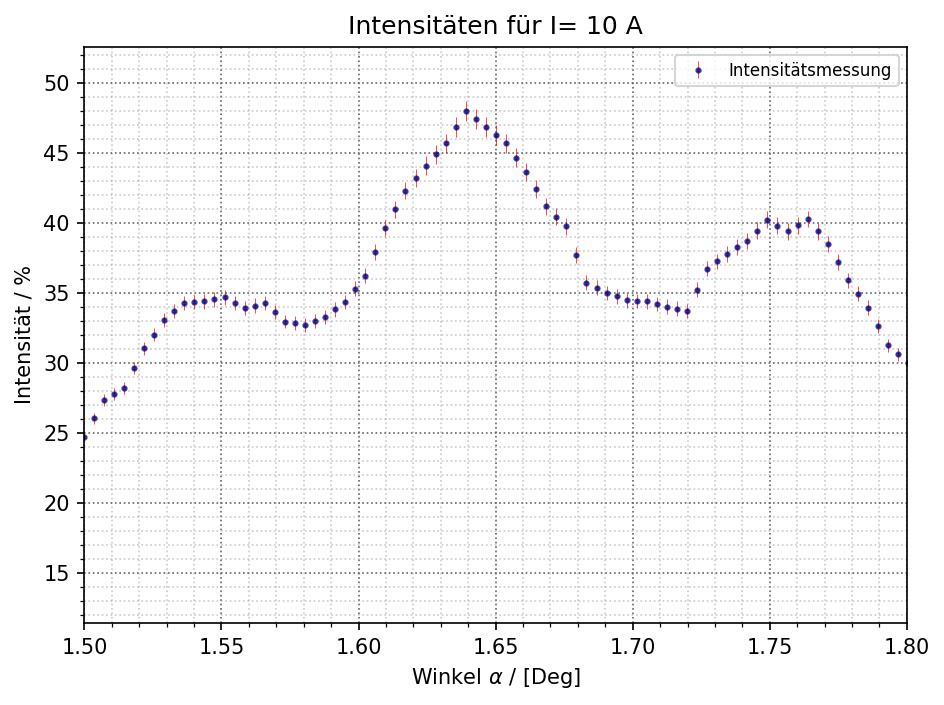

In [140]:
alldata_namen = ['ohne B', 'für I = 5,1 A', 'für I = 1 A', 'für I = 2 A', 'für I = 3 A', 'für I = 4 A', 'für I = 5 A', 'für I = 6 A', 'für I = 7 A', 'für I = 8 A', 'für I = 9 A', 'für I = 10 A']
alldata_benennung = ['ohne_B', 'mit_B', '1A', '2A', '3A', '4A', '5A', '6A', '7A', '8A', '9A', '10A']
dataB_namen = ['1 A', '2 A', '3 A', '4 A', '5 A', '6 A', '7 A', '8 A', '9 A', '10 A']
dataB_benennung = ['1A', '2A', '3A', '4A', '5A', '6A', '7A', '8A', '9A', '10A']
def plot(arr, int, int2, bool):
    #alpha = np.arctan(((1024-np.array(arr[:,0]))*0.014) / (150))
    alpha = (np.array(arr[:,0])*9.6e-6) / (0.15) * 180/np.pi
    #print(alpha)
    Imax = np.max(arr[:,1])
    I = np.array(arr[:,1])/Imax *50
    dI = I/100*1.5
    fig, ax = plt.subplots(num=2, dpi=150)
    plt.errorbar(alpha, I, yerr=dI, fmt='o', label='Intensitätsmessung',markersize=2, capsize=0, alpha=0.7, color='navy', ecolor='red', elinewidth=0.5)
    
    plt.grid(visible=True, which='major', color='#666666', linestyle=':')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle=':', alpha=0.5)
    plt.legend(prop={'size': 8}, loc = 'best')
    plt.xlabel(r'Winkel $\alpha$ / [Deg]')
    plt.ylabel(r'Intensität / %')
    if bool == True:
        plt.xlim([1.5,1.8])
        plt.title(fr'Intensitäten für I= {int}')
        #plt.savefig(f'plots/zeeman_plt/ZeemanX_{int2}.png', dpi=150)
    else:
        plt.plot(alpha, I)
        plt.title(fr'Intensitäten {int}')
        #plt.savefig(f'plots/zeeman_plt/ZeemanX_{int2}.png', dpi=150)
#        if int > 0:
#            plt.title(fr'Intensitäten für I= {int} A')
#        else:
#            plt.title(fr'Intensitäten für I= 0 A')
    plt.tight_layout()
    plt.show()
    
#for i in range(len(alldata)):
#    plot(alldata[i], alldata_namen[i],alldata_benennung[i], False)
for i in range(len(dataB)):
    plot(dataB[i], dataB_namen[i],dataB_benennung[i], True)
    

In [141]:
# jetzt fit
import lmfit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

deg= 3
model = lmfit.models.LinearModel(prefix='const')
for i in range(deg):
    model = model + lmfit.models.GaussianModel(prefix='gauss'+str(i+1))
    
peaks = [1.54, 1.64, 1.75]

params = model.make_params()
print(params.keys())

alpha_min = 1.5
alpha_max = 1.8

# Set initial values for the parameters
i = 0
for key in params.keys():
    # Default fallback values
    params[key].set(value=10)
    # Center Position for Peaks
    if key.endswith("center"):
        #params[key].set(value=peaks[i], min=0)
        params[key].set(value=peaks[i], min=alpha_min, max=alpha_max)
        i += 1
    # Widths
    if key.endswith("sigma"):
        params[key].set(value=0.01, min=0.002, max=0.1)
    # Amplitudes
    if key.endswith("amplitude"):
        params[key].set(value=30, min=0)

result_dic = []

'''
print("=======Initial Peak guesses===================")
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# Extract and filter
CCD = dataB[i]
alpha = (np.array(CCD[:, 0]) * 9.6e-6) / 0.15 * 180 / np.pi
mask = (alpha > alpha_min) & (alpha < alpha_max)
alpha_cut = alpha[mask]
intensity_cut = CCD[:, 1][mask]

# Normalize
intensity_norm = intensity_cut / np.max(intensity_cut) * 100

# Smooth and detect peaks
intensity_smoothed = gaussian_filter1d(intensity_norm, sigma=2)
peak_indices, _ = find_peaks(intensity_smoothed, distance=10)
peak_pos = alpha_cut[peak_indices]

# Get top 3 peaks
top3 = peak_indices[np.argsort(intensity_smoothed[peak_indices])][-3:]
peak_guesses = np.sort(alpha_cut[top3])

print("Peak guesses:", peak_guesses)
print("==========================================")
'''

print(model.components)
lin_a = np.zeros((10, 1))
lin_b = np.zeros((10, 1))
dlin_a = np.zeros((10, 1))
dlin_b = np.zeros((10, 1))
peaks = np.zeros((10, 3))
dpeaks = np.zeros((10, 3))
amp = np.zeros((10, 3))
damp = np.zeros((10, 3))
sigma = np.zeros((10, 3))
dsigma = np.zeros((10, 3))
chi_red = np.zeros((10, 3))

def plotpls(i):
    plt.close()
    
    # Extract data
    CCD = dataB[i]
    
    # Convert pixel to angle (deg) 
    alpha = (np.array(CCD[:,0])*9.6e-6) / (0.15) * 180/np.pi # winkel
    
    # Select data in alpha range
    mask = (alpha > alpha_min) & (alpha < alpha_max)
    alpha_cut = alpha[mask]
    intensity_cut = CCD[:,1][mask]
    
    # Normalize intensity
    intensity_norm = intensity_cut / np.max(intensity_cut) * 100
    dI = intensity_norm * 0.015
    
    # Smooth and detect peaks
    intensity_smoothed = gaussian_filter1d(intensity_norm, sigma=2)
    peak_indices, _ = find_peaks(intensity_smoothed, distance=10)
    peak_pos = alpha_cut[peak_indices]

    # Get top 3 peaks
    top3 = peak_indices[np.argsort(intensity_smoothed[peak_indices])][-3:]
    peak_guesses = np.sort(alpha_cut[top3])
    print(">>>>>>>>>Peak guesses:", peak_guesses)
    # Fit data
    result = model.fit(intensity_norm, params, x=alpha_cut, weights=1/dI)
    print(result.fit_report())
    ressum = result.summary()
    
    #data_cut = CCD[(alpha > alpha_min) & (alpha < alpha_max)]
    #data_cut[:,1] = data_cut[:,1] / np.max(data_cut[:,1]) * 100
    #dI = data_cut[:,1]/100*1.5
    #result = model.fit(data_cut[:,1], params, x=alpha[(alpha > alpha_min) & (alpha < alpha_max)], weights=1/dI)
    #print(result.fit_report())
    #ressum_dic = result.summary()
    #fig, ax = plt.subplots(num=2, dpi=150)
    
    # Store results
    lin_a[i] = [result.params['constslope'].value]
    dlin_a[i] = [result.params['constslope'].stderr]
    lin_b[i] = [result.params['constintercept'].value]
    dlin_b[i] = [result.params['constintercept'].stderr]
    
    peaks[i] = [result.params['gauss1center'].value, result.params['gauss2center'].value, result.params['gauss3center'].value]
    dpeaks[i] = [result.params['gauss1center'].stderr, result.params['gauss2center'].stderr, result.params['gauss3center'].stderr]
    
    amp[i] = [result.params['gauss1amplitude'].value, result.params['gauss2amplitude'].value, result.params['gauss3amplitude'].value]
    damp[i] = [result.params['gauss1amplitude'].stderr, result.params['gauss2amplitude'].stderr, result.params['gauss3amplitude'].stderr]
    
    sigma[i] = [result.params['gauss1sigma'].value, result.params['gauss2sigma'].value, result.params['gauss3sigma'].value]
    dsigma[i] = [result.params['gauss1sigma'].stderr, result.params['gauss2sigma'].stderr, result.params['gauss3sigma'].stderr]
    
    chi_red[i] = [ressum["redchi"]]
    
    # Plot
    fig, ax = plt.subplots(num=2, dpi=150)
    ax.errorbar(alpha_cut, intensity_norm, yerr=dI, fmt='o', label='Intensitätsmessung',markersize=2, capsize=0, alpha=0.7, color='navy', ecolor='red', elinewidth=0.5)
    
    x_fit = np.linspace(alpha_cut.min(), alpha_cut.max(), 1000)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-', label='Fit', linewidth=1)
    #x_fit = np.linspace(data_cut[:,0].min(), data_cut[:,0].max(), 100)
    
    ax.grid(visible=True, which='major', color='#666666', linestyle=':')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#999999', linestyle=':', alpha=0.5)
    
    ax.set_title(fr'Intensitäten für I= {dataB_namen[i]}')
    ax.set_xlabel(r'Winkel $\alpha$ / [Deg]')
    ax.set_ylabel(r'Intensität / %')
    ax.set_xlim([alpha_min, alpha_max])
    ax.legend(prop={'size': 8}, loc = 'best')
    
    #plt.errorbar(data_cut[:,0], data_cut[:,1], yerr=dI, fmt='o', label='Intensitätsmessung',markersize=2, capsize=0, alpha=0.7, color='navy', ecolor='red', elinewidth=0.5)
    #plt.plot(x_fit, result.eval(x=x_fit), 'r-', label='Fit', linewidth=1)
    #plt.grid(visible=True, which='major', color='#666666', linestyle=':')
    #plt.minorticks_on()
    #plt.grid(visible=True, which='minor', color='#999999', linestyle=':', alpha=0.5)
    #plt.legend(prop={'size': 8}, loc = 'best')
    #plt.title(fr'Intensitäten für I= {dataB_namen[i]}')
    #plt.xlabel(r'Winkel $\alpha$ / [Deg]')
    #plt.ylabel(r'Intensität / %')
    #plt.xlim([alpha_min, alpha_max])
    plt.tight_layout()
    plt.savefig(f'plots/zeeman_plt/peak_{dataB_benennung[i]}.png', dpi=150)
    #plt.show()
    plt.close()
    
    result_dic.append(result)
    
for i in range(0,10):
    plotpls(i)

print('====Latex time=====================')
# Print results in LaTeX format
def latex_stuff(data, data_err):
    if len(data_err) == 0:
        for j in range(len(data[0])):
            for i in range(len(data)):
                print(r'&', f'{data[i][j]}', end=' ')
            print(r'\\')
    else:
        for j in range(len(data[0])):
            for i in range(len(data)):
                print(r'&',f'{data[i][j]} ({data_err[i][j]})', end=' ')
            print(r'\\')
#latex_stuff(chi_red, [])    
#latex_stuff(lin_a, dlin_a)
#latex_stuff(lin_b, dlin_b)
latex_stuff(peaks, dpeaks)
#latex_stuff(amp, damp)
#latex_stuff(sigma, dsigma)  

def weird_err(data, data_err):
    if len(data_err) == 0:
        for j in range(len(data[0])):
            for i in range(len(data)):
                print(r'&', f'{data[i][j]}', end=' ')
            print(r'\\')
    else:
        for j in range(len(data[0])):
            for i in range(len(data)):
                print(r'&'+'{' + '\\' + 'num[round-mode=figures,round-precision=2]' + '{' + f'{data[i][j]}' + '}', '$\pm$', '\\' + 'num[round-mode=figures,round-precision=2]{' + f'{data_err[i][j]}' + '}' + '}', end=' ')
            print(r'\\')

#weird_err(lin_a, dlin_a) 
#weird_err(lin_b, dlin_b)
    

dict_keys(['constslope', 'constintercept', 'gauss1amplitude', 'gauss1center', 'gauss1sigma', 'gauss2amplitude', 'gauss2center', 'gauss2sigma', 'gauss3amplitude', 'gauss3center', 'gauss3sigma', 'gauss1fwhm', 'gauss1height', 'gauss2fwhm', 'gauss2height', 'gauss3fwhm', 'gauss3height'])
[Model(linear, prefix='const'), Model(gaussian, prefix='gauss1'), Model(gaussian, prefix='gauss2'), Model(gaussian, prefix='gauss3')]
>>>>>>>>>Peak guesses: [1.64645152]
[[Model]]
    (((Model(linear, prefix='const') + Model(gaussian, prefix='gauss1')) + Model(gaussian, prefix='gauss2')) + Model(gaussian, prefix='gauss3'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 477
    # data points      = 81
    # variables        = 11
    chi-square         = 94.0665597
    reduced chi-square = 1.34380800
    Akaike info crit   = 34.1138302
    Bayesian info crit = 60.4527709
    R-squared          = 0.99931801
[[Variables]]
    constslope:       5.69077138 +/- 1.84071985 (32.35%) (in

/home/jaalna/P4/p4env/lib/python3.10/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


>>>>>>>>>Peak guesses: [1.65011845]
[[Model]]
    (((Model(linear, prefix='const') + Model(gaussian, prefix='gauss1')) + Model(gaussian, prefix='gauss2')) + Model(gaussian, prefix='gauss3'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 250
    # data points      = 81
    # variables        = 11
    chi-square         = 121.434984
    reduced chi-square = 1.73478548
    Akaike info crit   = 54.7993180
    Bayesian info crit = 81.1382587
    R-squared          = 0.99858976
[[Variables]]
    constslope:      -39.5748984 +/- 70.8425340 (179.01%) (init = 10)
    constintercept:   84.3434156 +/- 102.582443 (121.62%) (init = 10)
    gauss1amplitude:  0.01291487 +/- 0.00873165 (67.61%) (init = 30)
    gauss1center:     1.53713371 +/- 0.00235369 (0.15%) (init = 1.54)
    gauss1sigma:      0.00457318 +/- 0.00275001 (60.13%) (init = 0.01)
    gauss2amplitude:  6.95106354 +/- 0.55079877 (7.92%) (init = 30)
    gauss2center:     1.64654371 +/- 0.00105318 (0.06%) (ini

In [142]:
# Constants
h = 6.626e-34           # Planck constant [J·s]
c = 3e8                 # Speed of light [m/s]
lambda_0 = 643.85e-9    # Wavelength in meters
n = 1.457               # Refractive index

# Precompute hc/λ
hc_lambda = h * c / lambda_0

# Convert angles from degrees to radians once
peaks_rad = np.deg2rad(peaks)      # shape (N, 3)
dpeaks_rad = np.deg2rad(dpeaks)    # same shape

# Extract π, σ⁻, σ⁺ peaks
pi   = peaks_rad[:, 0]
sigma_m = peaks_rad[:, 1]
sigma_p = peaks_rad[:, 2]

dpi   = dpeaks_rad[:, 0]
dsigma_m = dpeaks_rad[:, 1]
dsigma_p = dpeaks_rad[:, 2]

# Sine squares
sin2_pi   = np.sin(pi)**2
sin2_sigma_m = np.sin(sigma_m)**2
sin2_sigma_p = np.sin(sigma_p)**2

# Safe denominators
eps = 1e-6
denom_p = np.clip(sin2_pi - n**2, eps, None)
denom_m = np.clip(sin2_sigma_p - n**2, eps, None)

# Energy shifts
E_plus  = -hc_lambda * (1 - np.sqrt((sin2_sigma_m - n**2) / denom_p))
E_minus = -hc_lambda * (1 - np.sqrt((sin2_sigma_m - n**2) / denom_m))

# Error propagation
dE_plus = 0.1 * hc_lambda / np.sqrt((sin2_sigma_m - n**2) / denom_p) * np.sqrt(
    (np.sin(sigma_m) * np.cos(sigma_m) * dsigma_m / denom_p)**2 +
    (np.sin(pi) * np.cos(pi) * dpi * (sin2_sigma_m - n**2) / denom_p**2)**2
)

dE_minus = 0.1 * hc_lambda / 2 / np.sqrt((sin2_sigma_m - n**2) / denom_m) * np.sqrt(
    (np.sin(sigma_m) * np.cos(sigma_m) * 2 * dsigma_m / denom_m)**2 +
    (np.sin(sigma_p) * np.cos(sigma_p) * 2 * dsigma_p * (sin2_sigma_m - n**2) / denom_m**2)**2
)

# Output
print(f'{E_minus = }')
print(f'{dE_minus = }')
print('================================================================')
print(f'{E_plus = }')
print(f'{dE_plus = }')


E_minus = array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
dE_minus = array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
E_plus = array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
dE_plus = array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


/tmp/ipykernel_112238/3146925643.py:34: RuntimeWarning: invalid value encountered in sqrt
  E_plus  = -hc_lambda * (1 - np.sqrt((sin2_sigma_m - n**2) / denom_p))
/tmp/ipykernel_112238/3146925643.py:35: RuntimeWarning: invalid value encountered in sqrt
  E_minus = -hc_lambda * (1 - np.sqrt((sin2_sigma_m - n**2) / denom_m))
/tmp/ipykernel_112238/3146925643.py:38: RuntimeWarning: invalid value encountered in sqrt
  dE_plus = 0.1 * hc_lambda / np.sqrt((sin2_sigma_m - n**2) / denom_p) * np.sqrt(
/tmp/ipykernel_112238/3146925643.py:43: RuntimeWarning: invalid value encountered in sqrt
  dE_minus = 0.1 * hc_lambda / 2 / np.sqrt((sin2_sigma_m - n**2) / denom_m) * np.sqrt(


In [143]:
# Energieverschiebung
hc_lambda = 6.626E-34*3E8/(643.85E-9) # hc/lambda
n = 1.457 # Brechungsindex

print(np.sin(peaks[:,0]*np.pi/180)**2 - n**2)
print(np.sin(peaks[:,0]*np.pi/180)**2)
E_plus = -hc_lambda*(1-np.sqrt((np.power(np.sin(peaks[:,1]*np.pi/180), 2)-n*n)/(np.power(np.sin(peaks[:,0]*np.pi/180), 2)-n*n)))
E_minus = -hc_lambda*(1-np.sqrt((np.power(np.sin(peaks[:,1]*np.pi/180), 2)-n*n)/(np.power(np.sin(peaks[:,2]*np.pi/180), 2)-n*n)))
dE_plus = .1*hc_lambda*1/np.sqrt((np.power(np.sin(peaks[:,1]*np.pi/180), 2)-n*n)/(np.power(np.sin(peaks[:,0]*np.pi/180), 2)-n*n))\
            *np.sqrt(np.power(np.sin(peaks[:,1]*np.pi/180)*np.cos(peaks[:,1]*np.pi/180)*dpeaks[:,1]/(np.power(np.sin(peaks[:,0]*np.pi/180), 2)-n*n),2)\
            + np.power(np.sin(peaks[:,0]*np.pi/180)*np.cos(peaks[:,0]*np.pi/180)*dpeaks[:,0]/np.power(np.power(np.sin(peaks[:,0]*np.pi/180), 2)-n*n, 2)*(np.power(np.sin(peaks[:,1]*np.pi/180), 2)-n*n), 2))
dE_minus = .1*hc_lambda*1/2*1/np.sqrt((np.power(np.sin(peaks[:,1]*np.pi/180), 2)-n*n)/(np.power(np.sin(peaks[:,2]*np.pi/180), 2)-n*n))\
            *np.sqrt(np.power(np.sin(peaks[:,1]*np.pi/180)*np.cos(peaks[:,1]*np.pi/180)*2*dpeaks[:,1]/(np.power(np.sin(peaks[:,2]*np.pi/180), 2)-n*n),2)\
            + np.power(np.sin(peaks[:,2]*np.pi/180)*np.cos(peaks[:,2]*np.pi/180)*2*dpeaks[:,2]/np.power(np.power(np.sin(peaks[:,2]*np.pi/180), 2)-n*n, 2)*(np.power(np.sin(peaks[:,1]*np.pi/180), 2)-n*n), 2))
print(f'{E_minus = }')
print(f'{dE_minus = }')
print('================================================================')
print(f'{E_plus= }')
print(f'{dE_plus = }')

[-2.12210853 -2.12212943 -2.12209295 -2.12209586 -2.1220996  -2.12210778
 -2.12211635 -2.12212124 -2.12212609 -2.12212214]
[0.00074047 0.00071957 0.00075605 0.00075314 0.0007494  0.00074122
 0.00073265 0.00072776 0.00072291 0.00072686]
E_minus = array([4.96760428e-24, 5.76474773e-24, 4.54421714e-24, 4.18694639e-24,
       5.52452081e-24, 6.54754064e-24, 7.31786629e-24, 7.80128505e-24,
       7.82992408e-24, 8.71956637e-24])
dE_minus = array([5.76773907e-24, 2.38789223e-23, 2.14188818e-23, 1.35309646e-24,
       1.10137825e-24, 7.46073150e-25, 5.49250924e-25, 4.50190408e-25,
       5.13693326e-25, 8.42347981e-25])
E_plus= array([-6.04147025e-24, -7.71451447e-24, -4.88201874e-24, -3.67884040e-24,
       -4.68603179e-24, -5.57627880e-24, -6.38898697e-24, -6.80815176e-24,
       -7.22207328e-24, -6.83500014e-24])
dE_plus = array([1.51015133e-24, 1.01821315e-24, 6.79535013e-24, 1.14888712e-24,
       1.31285376e-24, 6.78989402e-25, 6.25540815e-25, 5.32379822e-25,
       8.41831101e-25, 4.59

1 & 1.0 (0.015) & 65.18436 (1.30869) \\
2 & 2.0 (0.03) & 131.78076 (2.64062) \\
3 & 3.0 (0.045) & 198.51772 (3.97535) \\
4 & 4.0 (0.06) & 263.61061 (5.27721) \\
5 & 5.0 (0.075) & 325.27482 (6.51050) \\
6 & 6.0 (0.09) & 381.72573 (7.63951) \\
7 & 7.0 (0.105) & 431.17873 (8.62857) \\
8 & 8.0 (0.12) & 471.84920 (9.44198) \\
9 & 9.0 (0.135) & 501.95252 (10.04405) \\
10 & 10.0 (0.15) & 519.70408 (10.39908) \\
B-Feld
[ 65.18436338 131.78076349 198.51771712 263.61060743 325.27481758
 381.72573073 431.17873004 471.84919867 501.95251978 519.70407653]
B-Feld Fehler
[ 1.30868727  2.64061527  3.97535434  5.27721215  6.51049635  7.63951461
  8.6285746   9.44198397 10.0440504  10.39908153]
Energie sigma +
[6.03735464e-24 7.70925914e-24 4.87869297e-24 3.67633427e-24
 4.68283954e-24 5.57248009e-24 6.38463462e-24 6.80351386e-24
 7.21715341e-24 6.83034395e-24]
Energie sigma + Fehler
[4.61982991e-25 3.48410566e-25 1.23898723e-24 3.49768964e-25
 4.49736284e-25 2.21744746e-25 2.08640071e-25 1.80919160e-25


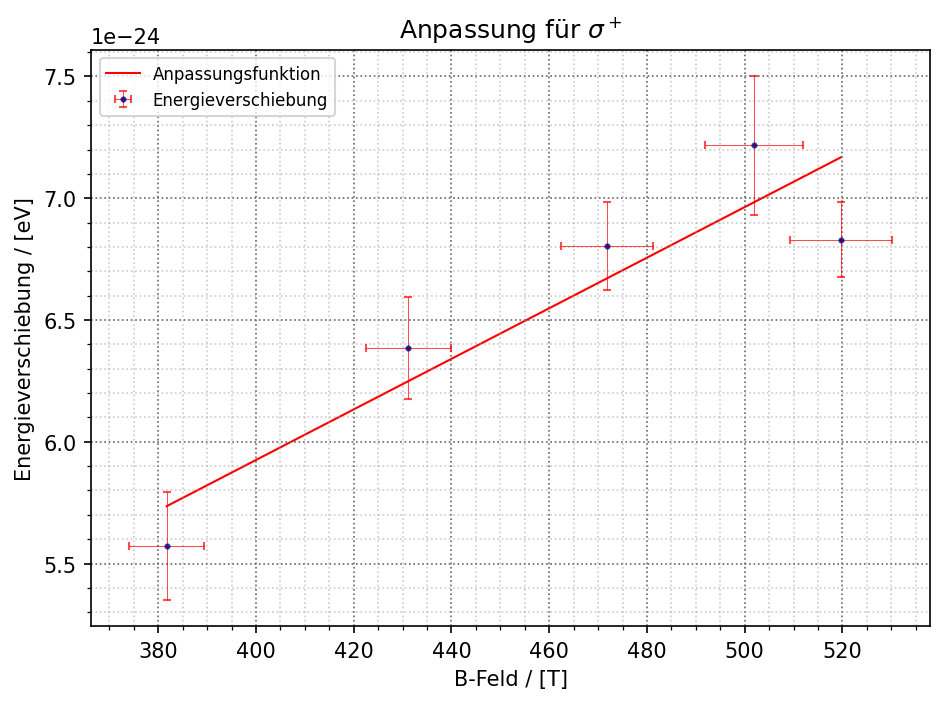

popt = array([2.39977171e-26, 3.12958452e-24])
pcov = array([[ 3.26922961e-54, -1.50803692e-51],
       [-1.50803692e-51,  7.03747391e-49]])


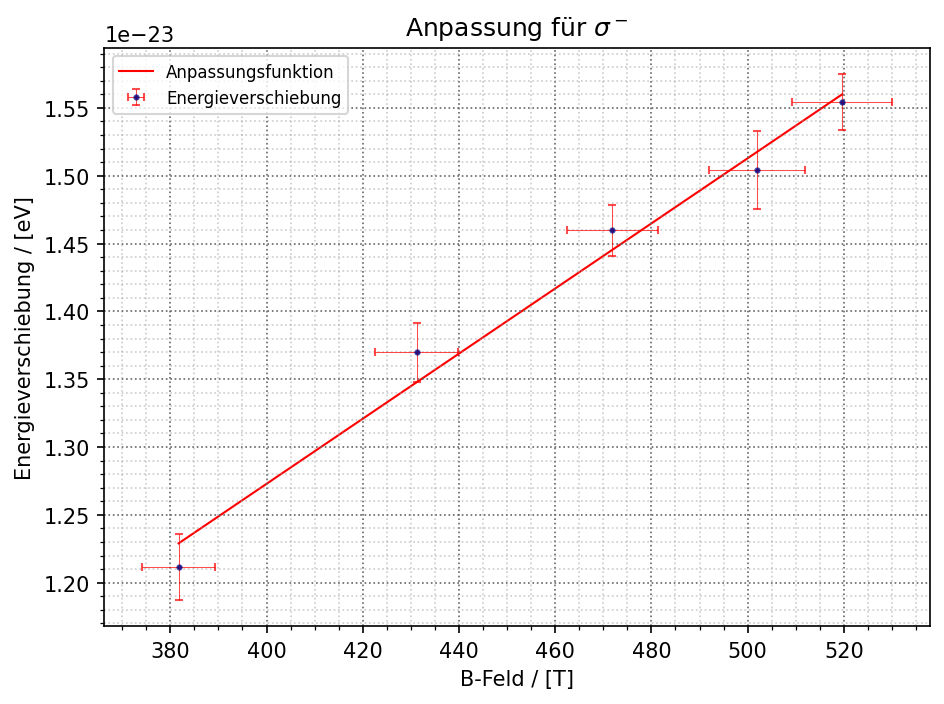

In [144]:
# Mit berechneten B-Fluss aus den Strömen
import scipy.constants as const
def linear_model(x, m, b):
    return m * x + b

def func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

degtorad = np.pi/180
popt_new = np.array([-0.29743614,  1.8548936 , 63.11377229,  0.51313363])
pcov_new = np.array([[ 9.61412109e-03, -1.25903006e-01,  3.66159077e-01,
        -9.36009482e-02],
       [-1.25903006e-01,  1.70986229e+00, -5.28784968e+00,
         1.52139259e+00],
       [ 3.66159077e-01, -5.28784968e+00,  1.83675657e+01,
        -6.84242492e+00],
       [-9.36009482e-02,  1.52139259e+00, -6.84242492e+00,
         7.37813128e+00]])

I = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
#I = np.array([6.0, 7.0, 8.0, 9.0, 10.0])
dI = 0.015*I
n = 1.457
lambda_0 = 643.85e-9
dlamda = 0.2e-9

def dI_new(I, int):
    return 0.02*func(I[int], *popt_new) +0.005

def E(n, api, asigma, lamb):
    return (const.h*const.c/lamb)*(1-np.sqrt((np.sin(api*degtorad)**2-n**2)/(np.sin(asigma*degtorad)**2-n**2)))

def dE(n, api, asigma, lamb, dapi, dasigma, dlamb):
    a = const.h * const.c / lamb
    b = E(n, api, asigma, lamb) * dlamb / lamb
    c = np.sin(api*degtorad) * np.cos(api*degtorad) * dapi*degtorad / ((n**2 - np.sin(asigma*degtorad)**2) * np.sqrt(
       (n**2 - np.sin(api*degtorad)**2)/(n**2 - np.sin(asigma*degtorad)**2)))
    d = ((n**2 - np.sin(api*degtorad)**2) * np.sin(asigma*degtorad) * np.cos(asigma*degtorad) * dasigma*degtorad) / ((n**2 - np.sin(asigma*degtorad)**2) * np.sqrt(
       (n**2 - np.sin(api*degtorad)**2)/(n**2 - np.sin(asigma*degtorad)**2)))
    return a*np.sqrt(b**2 + c**2 + d**2)

B = []
B_err = []

# sigma +
E1 = []
E1_err = []

# sigma -
E2 = []
E2_err = []

for i in range(len(I)):
    # B-Feld
    B.append(func(I[i], *popt_new))
    B_err.append(dI_new(I, i))
    
    # sigma +
    E1.append(E(n, peaks[i][1], peaks[i][0], lambda_0))
    E1_err.append(dE(n, peaks[i][1], peaks[i][0], lambda_0, dpeaks[i][1], dpeaks[i][0], dlamda))
    
    # sigma -
    E2.append(E(n, peaks[i][2], peaks[i][0], lambda_0))
    E2_err.append(dE(n, peaks[i][2], peaks[i][0], lambda_0, dpeaks[i][2], dpeaks[i][0], dlamda))
    
    print(fr'{i+1} & {I[i]} ({dI[i]}) & ' '%5.5f' % func(I[i], *popt_new), '(%5.5f)' % dI_new(I, i), r"\\")
    
B_arr = np.array(B)
B_err_arr = np.array(B_err)
E1_arr = np.array(E1)
E1_err_arr = np.array(E1_err)
E2_arr = np.array(E2)
E2_err_arr = np.array(E2_err)
print('B-Feld')
print(B_arr)
print('B-Feld Fehler')
print(B_err_arr)
print('Energie sigma +')
print(E1_arr)
print('Energie sigma + Fehler')
print(E1_err_arr)
print('Energie sigma -')
print(E2_arr)
print('Energie sigma - Fehler')
print(E2_err_arr)

# Slice the right values
B_fit = B_arr[5:]
B_err_fit = B_err_arr[5:]
E1_fit = E1_arr[5:]
E1_err_fit = E1_err_arr[5:]
E2_fit = E2_arr[5:]
E2_err_fit = E2_err_arr[5:]

def plot(arr, arr_err,B_sub, B_err_sub, i, bool):
    popt, pcov = curve_fit(linear_model, B_sub, arr)
    print(f'{popt = }')
    print(f'{pcov = }')
    
    fig, ax = plt.subplots(num=i, dpi=150)
    ax.plot(B_sub, linear_model(B_sub, *popt), 'r-', label='Anpassungsfunktion', linewidth=1, zorder=1)
    ax.errorbar(B_sub, arr, yerr=arr_err, xerr=B_err_sub, fmt='o', label='Energieverschiebung', markersize=2, capsize=2, alpha=0.7, color='navy', ecolor='red', elinewidth=0.5, zorder=2)
    ax.grid(visible=True, which='major', color='#666666', linestyle=':')
    ax.minorticks_on() 
    ax.grid(visible=True, which='minor', color='#999999', linestyle=':', alpha=0.5)
    ax.legend(prop={'size': 8}, loc = 'best')
    ax.set_xlabel(r'B-Feld / [T]')
    ax.set_ylabel(r'Energieverschiebung / [eV]')
    if bool == True:
        plt.title(fr'Anpassung für $\sigma^+$')
        plt.savefig(f'plots/zeeman_plt/E_mu_sigmaplus.png', dpi=150)
    else:
        plt.title(fr'Anpassung für $\sigma^-$')
        plt.savefig(f'plots/zeeman_plt/E_mu_sigmaminus.png', dpi=150)
    plt.tight_layout()
    plt.show()
    
    dict = {
        "popt": popt,
        "pcov": pcov,
    }
    return dict
#sigma_plus = plot(E1_arr, E1_err_arr, 3, True)
#sigma_minus = plot(E2_arr, E2_err_arr, 4, False)

sigma_plus = plot(E1_fit, E1_err_fit, B_fit, B_err_fit, 3, True)
sigma_minus = plot(E2_fit, E2_err_fit, B_fit, B_err_fit, 4, False)

#sigma_plus = plot(E_plus, dE_plus, 1, True)
#sigma_minus = plot(E_minus, dE_minus, 2, False)


In [145]:
for i in range(len(B_fit)):
    print(f'{B_fit[i]} ({B_err_fit[i]})', r'&', f'{E1_fit[i]*10**24} ({E1_err_fit[i]*10**24})', r'&', f'{E2_fit[i]*10**24} ({E2_err_fit[i]*10**24})',end=' ')
    print(r'\\')

381.72573073000007 (7.639514614600001) & 5.572480086607985 (0.22174474569721664) & 12.115303431844731 (0.24107032680226634) \\
431.17873004000006 (8.628574600800002) & 6.3846346237124445 (0.20864007056833905) & 13.697191127798385 (0.21668641768304878) \\
471.84919867 (9.441983973400001) & 6.803513860930767 (0.18091916015999185) & 14.5991155681459 (0.18818719072595302) \\
501.95251978000005 (10.044050395600001) & 7.217153412739329 (0.2860799558731307) & 15.04136206826291 (0.2848891867148429) \\
519.70407653 (10.3990815306) & 6.830343952104246 (0.15557627337997892) & 15.54353132346732 (0.20757688889071987) \\


In [146]:
# varianzgewichteter mittelwert
from scipy.odr import Model, RealData, ODR
def mittel_var(z, sigma):
    return np.sum(z/sigma**2)/np.sum(1/sigma**2)

def sigma2(n, sigma):
    return n/(np.sum(1/sigma**2))

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
    
def linreg_data(x,y,x_err,y_err, model):
    curve = Model(model)

    mydata = RealData(x, y, sx= x_err, sy= y_err)

    myodr = ODR(mydata, curve, beta0=[1., 2.])
    myoutput = myodr.run()
    myoutput.pprint()
    print('---------------------------- some stuff we need --------------------------------')
    # Auf die Ergebnisse zugreifen, z.B. die Parameter
    params = myoutput.beta
    params_err = myoutput.sd_beta
    print("Parameter:", params)
    print("Parameter_err:", params_err)

    # Die Residualvarianz
    residual_variance = myoutput.res_var
    print("Residual Variance:", residual_variance)

    # Das reduzierte Chi-Quadrat
    reduced_chi_squared = myoutput.res_var / (len(x) - len(myoutput.beta))
    print("Reduced Chi-Squared:", reduced_chi_squared)
    print('---------------------------- done --------------------------------')
    dict = {
        "params" : params,
        "params_err" : params_err,
        "residual_variance" : residual_variance,
        "reduced_chi_squared" : reduced_chi_squared
    }
    return dict

eplus = linreg_data(B_fit, E1_fit, B_err_fit, E1_err_fit, f)
eminus = linreg_data(B_fit, E2_fit, B_err_fit, E2_err_fit, f)

etot = np.abs(np.array([eplus["params"][0], eminus["params"][0]]))
etot_err = np.sqrt(np.array([eplus["params_err"][0], eminus["params_err"][0]]))
print('====================')
print(f'{etot = }')
print(f'{etot_err = }')
print('====================')
bohrfit = mittel_var(etot, etot_err)
bohrfit_err = np.sqrt(sigma2(len(etot), etot_err))
print('{', f'{bohrfit} ({bohrfit_err})', '}', '{\J \per \T}')

Beta: [9.73092774e-27 2.03263458e-24]
Beta Std Error: [2.59415336e-27 1.20955976e-24]
Beta Covariance: [[ 4.23972038e-54 -1.96631918e-51]
 [-1.96631918e-51  9.21723326e-49]]
Residual Variance: 1.5872819540086847
Inverse Condition #: 0.00022042928672754924
Reason(s) for Halting:
  Sum of squares convergence
---------------------------- some stuff we need --------------------------------
Parameter: [9.73092774e-27 2.03263458e-24]
Parameter_err: [2.59415336e-27 1.20955976e-24]
Residual Variance: 1.5872819540086847
Reduced Chi-Squared: 0.5290939846695616
---------------------------- done --------------------------------
Beta: [2.39642308e-26 3.17266969e-24]
Beta Std Error: [2.53427212e-27 1.16402938e-24]
Beta Covariance: [[ 8.08321611e-54 -3.69103859e-51]
 [-3.69103859e-51  1.70531882e-48]]
Residual Variance: 0.7945519567881458
Inverse Condition #: 0.0002346162254687303
Reason(s) for Halting:
  Both sum of squares and parameter convergence
---------------------------- some stuff we need --

In [147]:
z = np.abs(np.array([sigma_plus["popt"][0], sigma_minus["popt"][0]]))
sigma = np.array([sigma_plus["pcov"][0][0], sigma_minus["pcov"][0][0]])

print(sigma)
bohr = mittel_var(z, sigma)*10**(-24)
bohr_err = np.sqrt(sigma2(len(z), sigma))*10**(-24)

# print(bohr, "10^-24")
# print(bohr_err, "10^-24")
print(bohr)
print(bohr_err)

[6.20303577e-54 3.26922961e-54]
2.1038757551170575e-50
4.090104561475601e-78


dict_keys(['constslope', 'constintercept', 'gauss1amplitude', 'gauss1center', 'gauss1sigma', 'gauss2amplitude', 'gauss2center', 'gauss2sigma', 'gauss1fwhm', 'gauss1height', 'gauss2fwhm', 'gauss2height'])
[Model(linear, prefix='const'), Model(gaussian, prefix='gauss1'), Model(gaussian, prefix='gauss2')]
>>>>>>>>>Peak guesses: [1.01573958 1.29075932]
[[Model]]
    ((Model(linear, prefix='const') + Model(gaussian, prefix='gauss1')) + Model(gaussian, prefix='gauss2'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 194
    # data points      = 136
    # variables        = 8
    chi-square         = 1408.06866
    reduced chi-square = 11.0005364
    Akaike info crit   = 333.875440
    Bayesian info crit = 357.176679
    R-squared          = 0.99168957
[[Variables]]
    constslope:       8.67791424 +/- 1.15858130 (13.35%) (init = 10)
    constintercept:   13.7150680 +/- 1.30100051 (9.49%) (init = 10)
    gauss1amplitude:  4.50184130 +/- 0.07226186 (1.61%) (init =

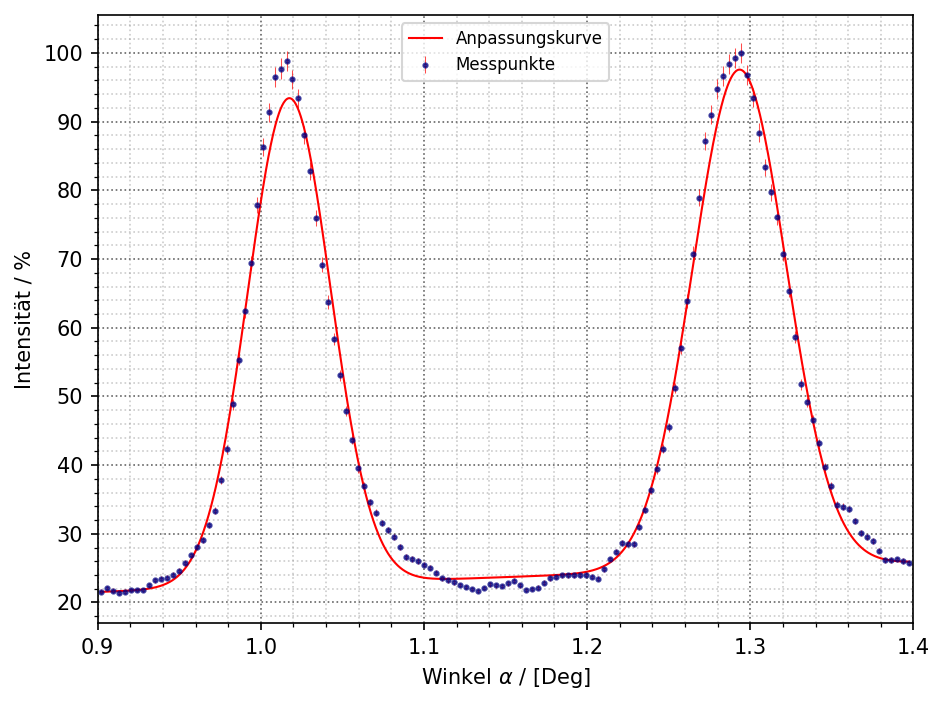

peaks = array([[1.01740153, 1.29334216]])
dpeaks = array([[0.00037771, 0.00042143]])
sigmafit = array([[0.02534067, 0.02864027]])
dsigmafit = array([[0.00035799, 0.0004188 ]])


In [149]:
import lmfit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

deg= 2

model = lmfit.models.LinearModel(prefix='const')
for i in range(deg):
    model = model + lmfit.models.GaussianModel(prefix='gauss'+str(i+1))
    
peaks = [0.9, 1.3]

params = model.make_params()
print(params.keys())

alpha_min = 0.9
alpha_max = 1.4

# Set initial values for the parameters
i = 0
for key in params.keys():
    # Default fallback values
    params[key].set(value=10)
    # Center Position for Peaks
    if key.endswith("center"):
        #params[key].set(value=peaks[i], min=0)
        params[key].set(value=peaks[i], min=alpha_min, max=alpha_max)
        i += 1
    # Widths
    if key.endswith("sigma"):
        params[key].set(value=0.01, min=0.002, max=0.1)
    # Amplitudes
    if key.endswith("amplitude"):
        params[key].set(value=30, min=0)

result_dic = []

print(model.components)
#lin_a = np.zeros((10, 1))
#lin_b = np.zeros((10, 1))
#dlin_a = np.zeros((10, 1))
#dlin_b = np.zeros((10, 1))
peaks = np.zeros((1, 2))
dpeaks = np.zeros((1, 2))
#amp = np.zeros((10, 3))
#damp = np.zeros((10, 3))
sigmafit = np.zeros((1, 2))
dsigmafit = np.zeros((1, 2))
#chi_red = np.zeros((10, 3))


plt.close()

# Extract data
CCD = data0

# Convert pixel to angle (deg) 
alpha = (np.array(CCD[:,0])*9.6e-6) / (0.15) * 180/np.pi # winkel

# Select data in alpha range
mask = (alpha > alpha_min) & (alpha < alpha_max)
alpha_cut = alpha[mask]
intensity_cut = CCD[:,1][mask]

# Normalize intensity
intensity_norm = intensity_cut / np.max(intensity_cut) * 100
dI = intensity_norm * 0.015

# Smooth and detect peaks
intensity_smoothed = gaussian_filter1d(intensity_norm, sigma=2)
peak_indices, _ = find_peaks(intensity_smoothed, distance=10)
peak_pos = alpha_cut[peak_indices]

# Get top 3 peaks
top3 = peak_indices[np.argsort(intensity_smoothed[peak_indices])][-2:]
peak_guesses = np.sort(alpha_cut[top3])
print(">>>>>>>>>Peak guesses:", peak_guesses)
# Fit data
result = model.fit(intensity_norm, params, x=alpha_cut, weights=1/dI)
print(result.fit_report())
ressum = result.summary()

# Store results
#lin_a[i] = [result.params['constslope'].value]
#dlin_a[i] = [result.params['constslope'].stderr]
#lin_b[i] = [result.params['constintercept'].value]
#dlin_b[i] = [result.params['constintercept'].stderr]

peaks[0] = [result.params['gauss1center'].value, result.params['gauss2center'].value]
dpeaks[0] = [result.params['gauss1center'].stderr, result.params['gauss2center'].stderr]

#amp[i] = [result.params['gauss1amplitude'].value, result.params['gauss2amplitude'].value, result.params['gauss3amplitude'].value]
#damp[i] = [result.params['gauss1amplitude'].stderr, result.params['gauss2amplitude'].stderr, result.params['gauss3amplitude'].stderr]

sigmafit[0] = [result.params['gauss1sigma'].value, result.params['gauss2sigma'].value]
dsigmafit[0] = [result.params['gauss1sigma'].stderr, result.params['gauss2sigma'].stderr]

#chi_red[i] = [ressum["redchi"]]

# Plot
fig, ax = plt.subplots(num=2, dpi=150)
ax.errorbar(alpha_cut, intensity_norm, yerr=dI, fmt='o', label='Messpunkte',markersize=2, capsize=0, alpha=0.7, color='navy', ecolor='red', elinewidth=0.5)

x_fit = np.linspace(alpha_cut.min(), alpha_cut.max(), 1000)
ax.plot(x_fit, result.eval(x=x_fit), 'r-', label='Anpassungskurve', linewidth=1)
#x_fit = np.linspace(data_cut[:,0].min(), data_cut[:,0].max(), 100)

ax.grid(visible=True, which='major', color='#666666', linestyle=':')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle=':', alpha=0.5)

#ax.set_title(fr'Intensitäten für I= {dataB_namen[i]}')
ax.set_xlabel(r'Winkel $\alpha$ / [Deg]')
ax.set_ylabel(r'Intensität / %')
ax.set_xlim([alpha_min, alpha_max])
ax.legend(prop={'size': 8}, loc = 'best')
plt.tight_layout()
plt.savefig(f'plots/zeeman_plt/finesse.png', dpi=150)
plt.show()
#plt.close()

print(f'{peaks = }')
print(f'{dpeaks = }')
print(f'{sigmafit = }')
print(f'{dsigmafit = }')

In [150]:
# Daren aus Anleitung
R = 0.85
T = 1-R
n = 1.457
d = 4e-3
lamb_pi = 643.85e-9
sigma = mittel_var(sigmafit, dsigmafit)
dsigma = np.sqrt(sigma2(len(sigmafit), dsigmafit))
print(f'sigma = {sigma} +/- {dsigma}')
print('====================')
F_theo = np.pi * np.sqrt(R)/(1-R)
A_theo = 2*n*d*F_theo/lamb_pi
print(f'A_theo = {A_theo}')
print(f'F_theo = {F_theo}')
print('----------------')
B_min_trans = func(4.7, *popt_new)
B_min_long = func(1.7, *popt_new)
print(f'{B_min_trans = }')
print(f'{B_min_long = }')
A_trans = const.h * const.c / (lamb_pi * B_min_trans * bohr)
A_trans_err = A_trans * bohr_err / bohr
F_trans = lamb_pi * A_trans/(2*n*d)
F_trans_err = lamb_pi * A_trans_err/(2*n*d)
print(f'{A_trans = }')
print(f'{A_trans_err = }')
print(f'{F_trans = }')
print(f'{F_trans_err = }')
print('----------------')
A_long = const.h * const.c / (lamb_pi * B_min_long * bohr)
A_long_err = A_long * bohr_err / bohr
F_long = lamb_pi * A_long/(2*n*d)
F_long_err = lamb_pi * A_long_err/(2*n*d)
print(f'{A_long = }')
print(f'{A_long_err = }')
print(f'{F_long = }')
print(f'{F_long_err = }')
print('----------------')

Finesse = np.abs(peaks[0][1] - peaks[0][0]) / (2 * np.sqrt(2 * np.log(2)) * sigma)
a = dpeaks[0][1] / (2 * np.sqrt(2 * np.log(2)) * sigma)
b = dpeaks[0][0] / (2 * np.sqrt(2 * np.log(2)) * sigma)
c = Finesse/sigma * dsigma
Finesse_err = np.sqrt(a**2 + b**2 + c**2)
Aufloesung = 2*n*d*Finesse/lamb_pi
Aufloesung_err = 2*n*d*Finesse_err / lamb_pi
print('-----------------')
print(f'{Finesse = }')
print(f'{Finesse_err = }')
print(f'{Aufloesung = }')
print(f'{Aufloesung_err = }')


sigma = 0.026733747155194953 +/- 0.00027212288063896265
A_theo = 349569.00246823777
F_theo = 19.309368757650553
----------------
B_min_trans = np.float64(307.24175065378)
B_min_long = np.float64(111.70588527118)
A_trans = np.float64(4.773003055798888e+28)
A_trans_err = np.float64(9.279103826819767)
F_trans = np.float64(2.6364945242588485e+24)
F_trans_err = np.float64(0.0005125558509692782)
----------------
A_long = np.float64(1.3127919009633764e+29)
A_long_err = np.float64(25.521735916861594)
F_long = np.float64(7.251553409705473e+24)
F_long_err = np.float64(0.001409760609992393)
----------------
-----------------
Finesse = np.float64(4.3832687870104605)
Finesse_err = np.float64(0.045513900476549726)
Aufloesung = np.float64(79352.92534191805)
Aufloesung_err = np.float64(823.9652464932261)
